<a href="https://colab.research.google.com/github/victwise/fastai/blob/master/Cap%C3%ADtulo6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from sklearn import datasets, linear_model, metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
import math, scipy, numpy as np
from scipy import linalg

In [0]:
np.set_printoptions(precision=6)

In [0]:
data = datasets.load_diabetes()

In [0]:
data = datasets.load_diabetes()

In [0]:
trn,test,y_trn,y_test = train_test_split(data.data, data.target, test_size=0.2)

In [16]:
trn.shape, test.shape

((353, 10), (89, 10))

In [0]:
def regr_metrics(act, pred):
    return (math.sqrt(metrics.mean_squared_error(act, pred)), 
     metrics.mean_absolute_error(act, pred))

##linalg.lstqr 
La implementación de sklearn se manejó agregando un término constante (ya que la intersección con y no es probablemente 0 para la línea ). 

In [0]:
trn_int = np.c_[trn, np.ones(trn.shape[0])]
test_int = np.c_[test, np.ones(test.shape[0])]

Ya que linalg.lstsqnos permite especificar qué rutina LAPACK queremos usar, probémoslos todos y hagamos algunas comparaciones de tiempo:

In [20]:
%timeit coef, _,_,_ = linalg.lstsq(trn_int, y_trn, lapack_driver="gelsd")

The slowest run took 111.75 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 3: 279 µs per loop


In [21]:
%timeit coef, _,_,_ = linalg.lstsq(trn_int, y_trn, lapack_driver="gelsy")

The slowest run took 6.96 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 165 µs per loop


In [22]:
%timeit coef, _,_,_ = linalg.lstsq(trn_int, y_trn, lapack_driver="gelss")

The slowest run took 11.11 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 3: 265 µs per loop


##Solución sencilla

In [0]:
def ls_naive(A, b):
     return np.linalg.inv(A.T @ A) @ A.T @ b

In [24]:
%timeit coeffs_naive = ls_naive(trn_int, y_trn)

The slowest run took 223.25 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 53 µs per loop


In [25]:
coeffs_naive = ls_naive(trn_int, y_trn)
regr_metrics(y_test, test_int @ coeffs_naive)

(50.87649500973857, 41.35749286895491)

##Ecuaciones Normales(Cholesky)

In [0]:
A = trn_int

In [0]:
b = y_trn

In [0]:
AtA = A.T @ A
Atb = A.T @ b

**Advertencia: ** Numpy y Scipy por defecto tienen Upper/lower diferentes en Cholesky

In [0]:
R = scipy.linalg.cholesky(AtA)

In [30]:
np.set_printoptions(suppress=True, precision=4)
R

array([[ 0.8846,  0.1581,  0.1731,  0.3252,  0.2362,  0.194 , -0.0626,
         0.183 ,  0.2418,  0.2806,  0.5877],
       [ 0.    ,  0.8804,  0.0395,  0.1548, -0.0256,  0.085 , -0.321 ,
         0.2456,  0.0669,  0.1612,  0.1847],
       [ 0.    ,  0.    ,  0.8821,  0.2672,  0.1721,  0.1792, -0.2957,
         0.3244,  0.3535,  0.3007,  0.0138],
       [ 0.    ,  0.    ,  0.    ,  0.7906,  0.0512, -0.0166,  0.011 ,
         0.0099,  0.1545,  0.1722,  0.5386],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.8094,  0.7219,  0.1125,
         0.4122,  0.3406,  0.1644, -0.7101],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.3865, -0.3917,
         0.261 , -0.338 , -0.0245, -0.5089],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.675 ,
        -0.5334, -0.5488, -0.1498, -0.1073],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
         0.3027, -0.0268,  0.0689,  0.1307],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
 

Revisando la factorización

In [31]:
np.linalg.norm(AtA - R.T @ R)

3.539601127436055e-16

In [0]:
w = scipy.linalg.solve_triangular(R, Atb, lower=False, trans='T')

In [33]:
np.linalg.norm(R.T @ w - Atb)

1.6140428288623166e-13

In [0]:
  coeffs_chol = scipy.linalg.solve_triangular(R, w, lower=False)

In [35]:
np.linalg.norm(R @ coeffs_chol - w)

4.691869230566371e-13

In [0]:
def ls_chol(A, b):
    R = scipy.linalg.cholesky(A.T @ A)
    w = scipy.linalg.solve_triangular(R, A.T @ b, trans='T')
    return scipy.linalg.solve_triangular(R, w)

In [37]:
%timeit coeffs_chol = ls_chol(trn_int, y_trn)

The slowest run took 9.65 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 132 µs per loop


In [38]:
coeffs_chol = ls_chol(trn_int, y_trn)
regr_metrics(y_test, test_int @ coeffs_chol)

(50.87649500973837, 41.35749286895471)

##Factorización QR

In [0]:
def ls_qr(A,b):
    Q, R = scipy.linalg.qr(A, mode='economic')
    return scipy.linalg.solve_triangular(R, Q.T @ b)

In [40]:
%timeit coeffs_qr = ls_qr(trn_int, y_trn)

The slowest run took 11.29 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 166 µs per loop


In [41]:
coeffs_qr = ls_qr(trn_int, y_trn)
regr_metrics(y_test, test_int @ coeffs_qr)

(50.87649500973839, 41.35749286895472)

##SVD

In [0]:
def ls_svd(A,b):
    m, n = A.shape
    U, sigma, Vh = scipy.linalg.svd(A, full_matrices=False, lapack_driver='gesdd')
    w = (U.T @ b)/ sigma
    return Vh.T @ w

In [43]:
%timeit coeffs_svd = ls_svd(trn_int, y_trn)

The slowest run took 4.22 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 3: 269 µs per loop


In [44]:
%timeit coeffs_svd = ls_svd(trn_int, y_trn)

The slowest run took 6.91 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 3: 267 µs per loop


In [45]:
coeffs_svd = ls_svd(trn_int, y_trn)
regr_metrics(y_test, test_int @ coeffs_svd)

(50.8764950097385, 41.35749286895473)

##Técnica de dibujo al azar para la regresión de mínimos cuadrados 

Dibujo lineal (Woodruff)

- Muestra arxn matriz aleatoria S, r << n
- Calcular SA y S b
- Encuentre la solución exacta x a la regresión SA x = Sb

In [0]:
import timeit
import pandas as pd

In [0]:
def scipylstq(A, b):
    return scipy.linalg.lstsq(A,b)[0]

In [0]:
row_names = ['Normal Eqns- Naive',
             'Normal Eqns- Cholesky', 
             'QR Factorization', 
             'SVD', 
             'Scipy lstsq']

name2func = {'Normal Eqns- Naive': 'ls_naive', 
             'Normal Eqns- Cholesky': 'ls_chol', 
             'QR Factorization': 'ls_qr',
             'SVD': 'ls_svd',
             'Scipy lstsq': 'scipylstq'}

In [0]:
m_array = np.array([100, 1000, 10000])
n_array = np.array([20, 100, 1000])

In [0]:
index = pd.MultiIndex.from_product([m_array, n_array], names=['# rows', '# cols'])

In [0]:
pd.options.display.float_format = '{:,.6f}'.format
df = pd.DataFrame(index=row_names, columns=index)
df_error = pd.DataFrame(index=row_names, columns=index)

In [52]:
# %%prun
for m in m_array:
    for n in n_array:
        if m >= n:        
            x = np.random.uniform(-10,10,n)
            A = np.random.uniform(-40,40,[m,n])   # removed np.asfortranarray
            b = np.matmul(A, x) + np.random.normal(0,2,m)
            for name in row_names:
                fcn = name2func[name]
                t = timeit.timeit(fcn + '(A,b)', number=5, globals=globals())
                df.set_value(name, (m,n), t)
                coeffs = locals()[fcn](A, b)
                reg_met = regr_metrics(b, A @ coeffs)
                df_error.set_value(name, (m,n), reg_met[0])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  del sys.path[0]


In [53]:
df

# rows                   100                    1000                     \
# cols                    20       100  1000     20       100      1000   
Normal Eqns- Naive    0.007973 0.004553  NaN 0.002328 0.016656 0.789696   
Normal Eqns- Cholesky 0.001040 0.006658  NaN 0.001284 0.006049 0.510102   
QR Factorization      0.001087 0.006425  NaN 0.003872 0.044941 1.271616   
SVD                   0.004084 0.069216  NaN 0.008536 0.117926 5.699254   
Scipy lstsq           0.003391 0.061438  NaN 0.005576 0.087808 3.463721   

# rows                   10000                     
# cols                    20       100       1000  
Normal Eqns- Naive    0.023852 0.143463  6.006322  
Normal Eqns- Cholesky 0.006776 0.064241  2.407535  
QR Factorization      0.027691 0.697593 11.452201  
SVD                   0.049638 0.862575 19.737812  
Scipy lstsq           0.034988 0.430731  9.978616

In [54]:
df_error

# rows                   100                    1000                     \
# cols                    20       100  1000     20       100      1000   
Normal Eqns- Naive    1.786005 0.000000  NaN 2.013661 1.844199 0.000000   
Normal Eqns- Cholesky 1.786005 0.000000  NaN 2.013661 1.844199 0.000000   
QR Factorization      1.786005 0.000000  NaN 2.013661 1.844199 0.000000   
SVD                   1.786005 0.000000  NaN 2.013661 1.844199 0.000000   
Scipy lstsq           1.786005 0.000000  NaN 2.013661 1.844199 0.000000   

# rows                   10000                    
# cols                    20       100      1000  
Normal Eqns- Naive    1.966557 1.994381 1.870033  
Normal Eqns- Cholesky 1.966557 1.994381 1.870033  
QR Factorization      1.966557 1.994381 1.870033  
SVD                   1.966557 1.994381 1.870033  
Scipy lstsq           1.966557 1.994381 1.870033

In [0]:
store = pd.HDFStore('least_squares_results.h5')

In [0]:
store['df'] = df

##Notas 
Utilicé el magick% prun para perfilar mi código.

Alternativa: mínima desviación absoluta (regresión L1)

Menos sensible a los valores atípicos que los mínimos cuadrados.

No hay solución de forma cerrada, pero se puede resolver con programación lineal.

##Ejemplo de condicionamiento 

In [0]:
A = [[1, 1000], [0, 1]]
B = [[1, 1000], [0.001, 1]]

In [0]:
wA, vrA = scipy.linalg.eig(A)
wB, vrB = scipy.linalg.eig(B)

In [59]:
wA, wB

(array([1.+0.j, 1.+0.j]), array([2.+0.j, 0.+0.j]))

##La inversión matricial es inestable 

In [0]:
from scipy.linalg import hilbert

In [0]:
n = 14
A = hilbert(n)
x = np.random.uniform(-10,10,n)
b = A @ x

In [0]:
A_inv = np.linalg.inv(A)

In [63]:
np.linalg.norm(np.eye(n) - A @ A_inv)

4.63098333381631

In [64]:
np.linalg.cond(A)

6.200786263161444e+17

In [65]:
A @ A_inv

array([[ 1.    ,  0.    ,  0.    ,  0.0003, -0.0008, -0.0033, -0.0557,
        -0.0587, -0.0236,  0.3125,  0.0879, -0.1484,  0.0065, -0.0569],
       [-0.    ,  1.    , -0.0001,  0.0014, -0.0126,  0.0785, -0.2299,
         0.2113, -0.2763,  0.625 , -0.9451, -0.1367,  0.1234, -0.0101],
       [ 0.    , -0.    ,  1.    , -0.0002,  0.002 ,  0.002 , -0.0469,
        -0.0156,  0.3125,  0.125 , -0.2812, -0.0312,  0.    , -0.0127],
       [ 0.    ,  0.    ,  0.    ,  0.9999,  0.0047, -0.0407,  0.0894,
        -0.6306,  0.9308, -1.4375,  1.2176, -1.0351,  0.4388, -0.0656],
       [ 0.    , -0.    ,  0.    , -0.    ,  1.0011,  0.0031,  0.0148,
        -0.1498,  0.4747,  0.    ,  0.2246, -0.0547,  0.0454, -0.0039],
       [ 0.    , -0.    ,  0.    , -0.0002,  0.0062,  0.964 ,  0.0511,
        -0.3853,  0.6504, -0.4688,  0.5615, -0.2886,  0.2377, -0.0267],
       [ 0.    , -0.    ,  0.    , -0.0005,  0.007 , -0.0264,  1.0179,
        -0.2277,  0.6103, -0.2188,  0.1478, -0.1211,  0.0712, -0.0013],

In [0]:
row_names = ['Normal Eqns- Naive',
             'QR Factorization', 
             'SVD', 
             'Scipy lstsq']

name2func = {'Normal Eqns- Naive': 'ls_naive', 
             'QR Factorization': 'ls_qr',
             'SVD': 'ls_svd',
             'Scipy lstsq': 'scipylstq'}

In [0]:
pd.options.display.float_format = '{:,.9f}'.format
df = pd.DataFrame(index=row_names, columns=['Time', 'Error'])

In [68]:
for name in row_names:
    fcn = name2func[name]
    t = timeit.timeit(fcn + '(A,b)', number=5, globals=globals())
    coeffs = locals()[fcn](A, b)
    df.set_value(name, 'Time', t)
    df.set_value(name, 'Error', regr_metrics(b, A @ coeffs)[0])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  


In [69]:
df

,Time,Error
Normal Eqns- Naive,0.003623464,2.055097427
QR Factorization,0.001393888,0.000000000
SVD,0.005120002,0.000000000
Scipy lstsq,0.001018512,0.000000000


In [70]:
df

,Time,Error
Normal Eqns- Naive,0.003623464,2.055097427
QR Factorization,0.001393888,0.000000000
SVD,0.005120002,0.000000000
Scipy lstsq,0.001018512,0.000000000


##QR

In [0]:
m=100
n=15
t=np.linspace(0, 1, m)

In [0]:
# Vandermonde matrix
A=np.stack([t**i for i in range(n)], 1)

In [0]:
b=np.exp(np.sin(4*t))

# This will turn out to normalize the solution to be 1
b /= 2006.787453080206

In [0]:
from matplotlib import pyplot as plt
%matplotlib inline

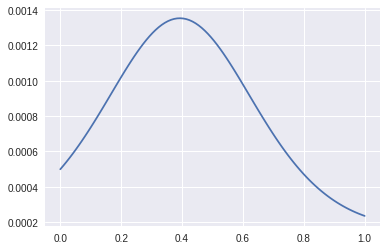

In [75]:
plt.plot(t, b)

In [76]:
1 - ls_qr(A, b)[14]

7.818991876185066e-08

In [77]:
kappa = np.linalg.cond(A); kappa

22717772123.079235

In [0]:
row_names = ['Normal Eqns- Naive',
             'QR Factorization', 
             'SVD', 
             'Scipy lstsq']

name2func = {'Normal Eqns- Naive': 'ls_naive', 
             'QR Factorization': 'ls_qr',
             'SVD': 'ls_svd',
             'Scipy lstsq': 'scipylstq'}

In [0]:
pd.options.display.float_format = '{:,.9f}'.format
df = pd.DataFrame(index=row_names, columns=['Time', 'Error'])

In [80]:
for name in row_names:
    fcn = name2func[name]
    t = timeit.timeit(fcn + '(A,b)', number=5, globals=globals())
    coeffs = locals()[fcn](A, b)
    df.set_value(name, 'Time', t)
    df.set_value(name, 'Error', np.abs(1 - coeffs[-1]))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  


In [81]:
df

,Time,Error
Normal Eqns- Naive,0.009902263,0.793144747
QR Factorization,0.002030079,0.000000078
SVD,0.002271685,0.000000078
Scipy lstsq,0.006447878,0.000000078


##Bajo rango

In [0]:
m = 100
n = 10
x = np.random.uniform(-10,10,n)
A2 = np.random.uniform(-40,40, [m, int(n/2)])   # removed np.asfortranarray
A = np.hstack([A2, A2])

In [83]:
A.shape, A2.shape

((100, 10), (100, 5))

In [0]:
b = A @ x + np.random.normal(0,1,m)

In [0]:
row_names = ['Normal Eqns- Naive',
             'QR Factorization', 
             'SVD', 
             'Scipy lstsq']

name2func = {'Normal Eqns- Naive': 'ls_naive', 
             'QR Factorization': 'ls_qr',
             'SVD': 'ls_svd',
             'Scipy lstsq': 'scipylstq'}

In [0]:
pd.options.display.float_format = '{:,.9f}'.format
df = pd.DataFrame(index=row_names, columns=['Time', 'Error'])

Desde Trefethen (página 84):

Ecuaciones normales / Cholesky es más rápido cuando funciona. Cholesky solo se puede utilizar en matrices definidas positivas simétricas. Además, las ecuaciones normales / Cholesky son inestables para matrices con números de condición altos o con rango bajo.

La regresión lineal a través de QR ha sido recomendada por los analistas numéricos como el método estándar durante años. Es natural, elegante y bueno para el "uso diario".